# Финальный проект курса «Аналитик данных» от Karpov Courses  
Таранова Елена

### Цель
*Представьте, что вы работаете в крупном дейтинговом приложении.*

*Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.*

### Проблема

*Выявить, был ли эксперимент успешен в целом. И(или) имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.*

### Результат анализа  

Анализ показал, что есть статистически значимые различия между контрольной и тестовыми группами. Нововведение  значимо увеличивает средний чек на 1200 - 4200 среди платящих пользователей!

### Анализ

1. Для оценки статистической значимости был применен бустрэп, посколько выборки небольшие и этот метод позволяет построить доверительные интервалыразницы средних. 
2. Мы посчитали основные метрики по всему датасету, которые показали, что изменения стоимости подписки повлияли на конверсию в покупателя и конверсию в премиум-подписку. В то же время мы получили увеличение среднего чека, а показатель повторных покупок при этом не изменился. Что говорит о удачном тесте для платящих покупателей (или же лояльных покупателей, что дальше также подтверждается).
3. В попытках найти зацепки для оценки, на какие именно группы могли позитивно повлиять изменения, были:

        - Исследованы группы по 
                - странам (country), 
                - возрасту (age), 
                - гендеру и 
                - интенсивности использования (views_count)
        - Найдены показатели лояльности (was_premium)

### Рекомендации 
Исследование показало, что смысл выкатывать обновление есть. Однако, лучше всего его оставить на уже лояльных пользователей (которые до этого покупали подписку (was_premium). Ожидаемый эффект от этого изменения - увеличение среднего чека на 1200-4200.

Дополнительно имеет смысл понаблюдать за отдельными категориями: 

    - страны Argentina и Italia
    - возраст до 25 лет и старше 38 
    - интенсивно использует приложение

________

### Загрузка и обработка данных

In [49]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import norm, mannwhitneyu
from tqdm.auto import tqdm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('max_rows', 100)
pd.set_option('max_columns', 100)
%autosave 30

Autosaving every 30 seconds


In [50]:
#Настройки для отображения графиков plotly
plot_config = {
    "template": "simple_white",
    "color": 'group_id',
    "color_discrete_sequence": px.colors.qualitative.Set2,
    "height": 400,
    'width': 800
}

In [51]:
#загрузка табличек
trans1_raw = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/84jzzJeQ4tqVyg', sep=';')
trans2_raw = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/_pOo7mrDCZZMyA', sep=';')
transtest_raw = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/3viYBnm7cyihkQ', sep=';')
users1_raw = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/TxOD_JxnkMd4mA', sep=';')
users2_raw = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/YT6OWRK2cTWfLg', sep=';')
userstest_raw = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/L8HxRYDn2l4h9A', sep=';')

In [52]:
def convert(data_):
    '''function performs data types' transformations'''
    data = data_.dropna(subset=['uid'])

    if 'revenue' in data.columns:
        dict_type_for_trans = {'uid': 'int',
                               'country': 'str',
                               'joined_at': 'str',
                               'paid_at': 'str',
                               'revenue': 'float',
                               'payment_id': 'int',
                               'from_page': 'str',
                               'product_type': 'str'}

        data = data.astype(dict_type_for_trans)
        data['joined_at'] = pd.to_datetime(data['joined_at'])
        data['paid_at'] = pd.to_datetime(data['paid_at'])

    else:

        dict_type_for_users = {'uid': 'int',
                               'age': 'int',
                               'attraction_coeff': 'int',
                               'country': 'str',
                               'visit_days': 'str',
                               'coins': 'float',
                               'gender': 'int',
                               'age_filter_start': 'int',
                               'age_filter_end': 'int',
                               'views_count': 'int',
                               'total_revenue': 'float'}

        data = data.astype(dict_type_for_users)

    return data

In [53]:
trans_1 = convert(trans1_raw)
trans_2 = convert(trans2_raw)
trans_test = convert(transtest_raw)
users_1 = convert(users1_raw)
users_2 = convert(users2_raw)
users_test = convert(userstest_raw)

In [54]:
group_1 = pd.merge(users_1, trans_1, on='uid', how='left')
group_1.was_premium = group_1.was_premium.fillna(0)
group_1.is_premium = group_1.is_premium.fillna(0)

In [55]:
group_2 = pd.merge(users_2, trans_2, on='uid', how='left')
group_2.was_premium = group_2.was_premium.fillna(0)
group_2.is_premium = group_2.is_premium.fillna(0)

In [56]:
group_test = pd.merge(users_test, trans_test, on='uid', how='left')
group_test.was_premium = group_test.was_premium.fillna(0)
group_test.is_premium = group_test.is_premium.fillna(0)

In [57]:
names = ['cntr1', 'cntr2', 'test']
for i, df in zip(names, [group_1, group_2, group_test]):
    df['group_id'] = i
    
united_df = pd.concat([group_1, group_2, group_test])

In [58]:
# Проверки, что ничего не потерялось
print(group_1.uid.count() + group_2.uid.count() + group_test.uid.count() == united_df.uid.count())
print(group_1.uid.nunique() + group_2.uid.nunique() + group_test.uid.nunique() == united_df.uid.nunique())

True
True


### Чистим данные:

       - united_df - общий датасет с правильными форматами данных\
       - united_df_upd1 - united_df без 2015 года \
       - united_df_upd2 - united_df1 с исправленной ошибкой перепутанных месяц и дня в joined_at \
       - united_df_upd3 - united_df2 с исправленной ошибкой перепутанных месяц и дня в paid_at

In [59]:
# Посмотрим на даты, тут, вероятно, какая-то ошибка, так как есть данные за 2015
united_df['only_start_date'] = united_df['joined_at'].dt.date
set(united_df.only_start_date.unique())

/Users/alyoneen/myenv/lib/python3.8/site-packages/IPython/lib/pretty.py:129: FutureWarning:

Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.



{NaT,
 datetime.date(2015, 1, 19),
 datetime.date(2017, 1, 11),
 datetime.date(2017, 2, 11),
 datetime.date(2017, 3, 11),
 datetime.date(2017, 4, 11),
 datetime.date(2017, 5, 11),
 datetime.date(2017, 6, 11),
 datetime.date(2017, 7, 11),
 datetime.date(2017, 8, 11),
 datetime.date(2017, 9, 11),
 datetime.date(2017, 10, 11),
 datetime.date(2017, 10, 14),
 datetime.date(2017, 10, 15),
 datetime.date(2017, 10, 16),
 datetime.date(2017, 10, 17),
 datetime.date(2017, 10, 18),
 datetime.date(2017, 10, 19),
 datetime.date(2017, 10, 20),
 datetime.date(2017, 10, 21),
 datetime.date(2017, 10, 22),
 datetime.date(2017, 10, 23),
 datetime.date(2017, 10, 24),
 datetime.date(2017, 10, 25),
 datetime.date(2017, 10, 26),
 datetime.date(2017, 10, 27),
 datetime.date(2017, 10, 28),
 datetime.date(2017, 10, 29),
 datetime.date(2017, 10, 30),
 datetime.date(2017, 10, 31)}

In [60]:
# Это всего лишь 3 записи от одного человека, вероятно, попала она сюда по ошибке. 
united_df = united_df[united_df['only_start_date'] != datetime(2015, 1, 19).date()]

Кроме того, я вижу ошибку при парсинге дат. В части данных за ноябрь местами перепутаны день и месяц.
Чтобы это подтвердить, я посмотрела на разницу между joined_at и paid_at. \
Если есть оплаты раньше, чем регистрация в приложении, то вероятно, действительно ошибка. 
Вижу, что есть события оплаты, которые произошли ранее, чем регистрация. В каждом из этих случаев виноват ноябрь! 

Далее поправлю эту ошибку с помощью метода datetime.strftime

In [61]:
united_df['diff_to_pay'] = united_df['paid_at'] - united_df['joined_at']
united_df[united_df['diff_to_pay'] < timedelta(days=0, seconds=1)].head(5)

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type,group_id,only_start_date,diff_to_pay
210,891973917,25,125,NaN,France,"2,3,5,6,7,9,10,12,13,14,16,18,20,22",1,22,28,8,1.0,1.0,6344.0,France,2017-10-23 18:31:00,2017-02-11 19:03:00,6344.0,147.0,promo_09,premium_no_trial,cntr1,2017-10-23,-254 days +00:32:00
296,892421277,22,446,62.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,16,35,130,1.0,1.0,60333.0,United States of America,2017-10-14 13:05:00,2017-02-11 02:12:00,12610.0,19.0,empty_likes,coins,cntr1,2017-10-14,-246 days +13:07:00
661,892120956,58,183,NaN,Belgium,"1,6,12,13,14,15,16,18,19",1,36,54,278,1.0,1.0,3042.0,Belgium,2017-10-20 18:20:00,2017-05-11 13:43:00,3042.0,68.0,none,premium_no_trial,cntr1,2017-10-20,-163 days +19:23:00
1010,891693753,24,311,50.0,Turkey,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,18,40,478,1.0,1.0,13026.0,Turkey,2017-10-29 15:24:00,2017-04-11 20:45:00,5304.0,19.0,empty_likes,coins,cntr1,2017-10-29,-201 days +05:21:00
1012,891693753,24,311,50.0,Turkey,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,18,40,478,1.0,1.0,13026.0,Turkey,2017-10-29 15:24:00,2017-06-11 22:30:00,3432.0,147.0,promo_09,premium_no_trial,cntr1,2017-10-29,-140 days +07:06:00


Поработаем над преобразованием дат в joined_at:

In [62]:
# Проверяем даты в joined_at:
united_df['start_date_joined'] = united_df['joined_at'].dt.date
print(united_df.start_date_joined.nunique())
set(united_df.start_date_joined.unique())

28


/Users/alyoneen/myenv/lib/python3.8/site-packages/IPython/lib/pretty.py:129: FutureWarning:

Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.



{NaT,
 datetime.date(2017, 1, 11),
 datetime.date(2017, 2, 11),
 datetime.date(2017, 3, 11),
 datetime.date(2017, 4, 11),
 datetime.date(2017, 5, 11),
 datetime.date(2017, 6, 11),
 datetime.date(2017, 7, 11),
 datetime.date(2017, 8, 11),
 datetime.date(2017, 9, 11),
 datetime.date(2017, 10, 11),
 datetime.date(2017, 10, 14),
 datetime.date(2017, 10, 15),
 datetime.date(2017, 10, 16),
 datetime.date(2017, 10, 17),
 datetime.date(2017, 10, 18),
 datetime.date(2017, 10, 19),
 datetime.date(2017, 10, 20),
 datetime.date(2017, 10, 21),
 datetime.date(2017, 10, 22),
 datetime.date(2017, 10, 23),
 datetime.date(2017, 10, 24),
 datetime.date(2017, 10, 25),
 datetime.date(2017, 10, 26),
 datetime.date(2017, 10, 27),
 datetime.date(2017, 10, 28),
 datetime.date(2017, 10, 29),
 datetime.date(2017, 10, 30),
 datetime.date(2017, 10, 31)}

In [63]:
# Сохраним в отдельный датасет все ошибочные данные за "неправильный ноябрь". 
wrong_november = united_df[(united_df['joined_at'] < datetime(2017, 10, 1))]
wrong_november['joined_at'] = wrong_november['joined_at']\
                .apply(lambda x: datetime.strftime(x, '%Y-%d-%m %H:%M:%S')) #исправляем
wrong_november['joined_at'] = pd.to_datetime(wrong_november['joined_at'])

# И неправильное 11 октября
eleven_october = united_df[(united_df['joined_at'] > datetime(2017, 10, 10)) &
              (united_df['joined_at'] < datetime(2017, 10, 12))]
eleven_october['joined_at'] = eleven_october['joined_at']\
                .apply(lambda x: datetime.strftime(x, '%Y-%d-%m %H:%M:%S')) #исправляем
eleven_october['joined_at'] = pd.to_datetime(eleven_october['joined_at'])

# И правильный Октябрь
right_october = united_df[(united_df['joined_at'] > datetime(2017, 10, 12))]

# Данные без дат 
without_dates = united_df[(united_df['joined_at'].isnull())]

# Проверим, что ничего не потерялось 
print(united_df.joined_at.count() == wrong_november.joined_at.count() \
                                + eleven_october.joined_at.count() \
                                + right_october.joined_at.count()
)
print(united_df.uid.count() == wrong_november.uid.count() \
                            + eleven_october.uid.count() \
                            + right_october.uid.count() \
                            + without_dates.uid.count())

True
True


<ipython-input-63-9ad1fbfc4655>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-63-9ad1fbfc4655>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-63-9ad1fbfc4655>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-63-9ad1fb

In [64]:
united_df = pd.concat([wrong_november, 
                             eleven_october, 
                             right_october, 
                             without_dates])

In [65]:
#Проверим, что все хорошо с данными
united_df['start_date_joined'] = united_df['joined_at'].dt.date
print(united_df.start_date_joined.nunique())
set(united_df.start_date_joined.unique())

28


{datetime.date(2017, 10, 21),
 NaT,
 datetime.date(2017, 10, 14),
 datetime.date(2017, 10, 15),
 datetime.date(2017, 10, 16),
 datetime.date(2017, 10, 17),
 datetime.date(2017, 10, 18),
 datetime.date(2017, 10, 19),
 datetime.date(2017, 10, 20),
 datetime.date(2017, 10, 22),
 datetime.date(2017, 10, 23),
 datetime.date(2017, 10, 24),
 datetime.date(2017, 10, 25),
 datetime.date(2017, 10, 26),
 datetime.date(2017, 10, 27),
 datetime.date(2017, 10, 28),
 datetime.date(2017, 10, 29),
 datetime.date(2017, 10, 30),
 datetime.date(2017, 10, 31),
 datetime.date(2017, 11, 1),
 datetime.date(2017, 11, 2),
 datetime.date(2017, 11, 3),
 datetime.date(2017, 11, 4),
 datetime.date(2017, 11, 5),
 datetime.date(2017, 11, 6),
 datetime.date(2017, 11, 7),
 datetime.date(2017, 11, 8),
 datetime.date(2017, 11, 9),
 datetime.date(2017, 11, 10)}

In [66]:
#данные на графике стали также выглядеть лучше 
px.histogram(united_df, 
             x='start_date_joined', 
             **plot_config,
             nbins=100)

In [67]:
#Проверяем даты в paid_at и там все та же ошибка
united_df['start_date_paid'] = united_df['paid_at'].dt.date
print(united_df.start_date_paid.nunique())
set(united_df.start_date_paid.unique())

33


{datetime.date(2017, 10, 21),
 NaT,
 datetime.date(2017, 1, 11),
 datetime.date(2017, 2, 11),
 datetime.date(2017, 3, 11),
 datetime.date(2017, 4, 11),
 datetime.date(2017, 5, 11),
 datetime.date(2017, 6, 11),
 datetime.date(2017, 7, 11),
 datetime.date(2017, 8, 11),
 datetime.date(2017, 9, 11),
 datetime.date(2017, 10, 11),
 datetime.date(2017, 10, 14),
 datetime.date(2017, 10, 15),
 datetime.date(2017, 10, 16),
 datetime.date(2017, 10, 17),
 datetime.date(2017, 10, 18),
 datetime.date(2017, 10, 19),
 datetime.date(2017, 10, 20),
 datetime.date(2017, 10, 22),
 datetime.date(2017, 10, 23),
 datetime.date(2017, 10, 24),
 datetime.date(2017, 10, 25),
 datetime.date(2017, 10, 26),
 datetime.date(2017, 10, 27),
 datetime.date(2017, 10, 28),
 datetime.date(2017, 10, 29),
 datetime.date(2017, 10, 30),
 datetime.date(2017, 10, 31),
 datetime.date(2017, 11, 11),
 datetime.date(2017, 11, 13),
 datetime.date(2017, 11, 14),
 datetime.date(2017, 11, 15),
 datetime.date(2017, 12, 11)}

Теперь поработаем над преобразованием дат в paid_at:

In [68]:
#Сохраним в отдельный датасет все ошибочные данные за "неправильный ноябрь" по paid_at: 
wrong_november_2 = united_df[(united_df['paid_at'] < datetime(2017, 10, 1)) |
                                 (united_df['paid_at'] > datetime(2017, 12, 10))]
wrong_november_2['paid_at'] = wrong_november_2['paid_at']\
                .apply(lambda x: datetime.strftime(x, '%Y-%d-%m %H:%M:%S')) #исправляем
wrong_november_2['paid_at'] = pd.to_datetime(wrong_november_2['paid_at'])

#И неправильное 11 октября
eleven_october_2 = united_df[(united_df['paid_at'] > datetime(2017, 10, 10)) &
              (united_df['paid_at'] < datetime(2017, 10, 12))]
eleven_october_2['paid_at'] = eleven_october_2['paid_at']\
                .apply(lambda x: datetime.strftime(x, '%Y-%d-%m %H:%M:%S')) #исправляем
eleven_october_2['paid_at'] = pd.to_datetime(eleven_october_2['paid_at'])


#И правильный Октябрь 
right_october_2 = united_df[(united_df['paid_at'] > datetime(2017, 10, 12)) &
                                 (united_df['paid_at'] < datetime(2017, 11, 1))]

#Правильный ноябрь
right_november_2 = united_df[(united_df['paid_at'] > datetime(2017, 11, 10)) &
                                 (united_df['paid_at'] < datetime(2017, 11, 16))]


#Данные без дат 
without_dates_2 = united_df[(united_df['paid_at'].isnull())]

#Проверим, что ничего не потерялось (879) != (975)
print(united_df.paid_at.count() == wrong_november_2.paid_at.count() \
                                + eleven_october_2.paid_at.count() \
                                + right_october_2.paid_at.count()\
                                + right_november_2.paid_at.count()
)
print(united_df.uid.count() == wrong_november_2.uid.count() \
                            + eleven_october_2.uid.count() \
                            + right_october_2.uid.count() \
                            + right_november_2.uid.count() \
                            + without_dates_2.uid.count())

True
True


<ipython-input-68-1508238fb58f>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-68-1508238fb58f>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-68-1508238fb58f>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-68-150823

In [69]:
united_df = pd.concat([wrong_november_2, 
                             eleven_october_2, 
                             right_october_2,
                             right_november_2,
                             without_dates_2])

In [70]:
#Проверяем, все ли исправилось? Да, все ок.
united_df['start_date_paid'] = united_df['paid_at'].dt.date
print(united_df.start_date_paid.nunique())
set(united_df.start_date_paid.unique())

33


{datetime.date(2017, 10, 21),
 NaT,
 datetime.date(2017, 10, 14),
 datetime.date(2017, 10, 15),
 datetime.date(2017, 10, 16),
 datetime.date(2017, 10, 17),
 datetime.date(2017, 10, 18),
 datetime.date(2017, 10, 19),
 datetime.date(2017, 10, 20),
 datetime.date(2017, 10, 22),
 datetime.date(2017, 10, 23),
 datetime.date(2017, 10, 24),
 datetime.date(2017, 10, 25),
 datetime.date(2017, 10, 26),
 datetime.date(2017, 10, 27),
 datetime.date(2017, 10, 28),
 datetime.date(2017, 10, 29),
 datetime.date(2017, 10, 30),
 datetime.date(2017, 10, 31),
 datetime.date(2017, 11, 1),
 datetime.date(2017, 11, 2),
 datetime.date(2017, 11, 3),
 datetime.date(2017, 11, 4),
 datetime.date(2017, 11, 5),
 datetime.date(2017, 11, 6),
 datetime.date(2017, 11, 7),
 datetime.date(2017, 11, 8),
 datetime.date(2017, 11, 9),
 datetime.date(2017, 11, 10),
 datetime.date(2017, 11, 11),
 datetime.date(2017, 11, 12),
 datetime.date(2017, 11, 13),
 datetime.date(2017, 11, 14),
 datetime.date(2017, 11, 15)}

In [71]:
#На графике тоже видим, что теперь все хорошо 
px.histogram(united_df, 
             x='start_date_paid', 
             **plot_config,
             labels={"start_date_paid": "дата регистрации"},
             nbins=100)

In [72]:
#обновим данные по diff_to_pay и проверим, остались ли проблемы. Как видим, больше их нет
united_df['diff_to_pay'] = united_df['paid_at'] - united_df['joined_at']
united_df[united_df['diff_to_pay'] < timedelta(days=0, seconds=1)].head(5)

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type,group_id,only_start_date,diff_to_pay,start_date_joined,start_date_paid


In [73]:
united_df['revenue'].fillna(0, inplace=True)

__________

### Тесты 

Проводим А/А-тест и видим, что наши контрольные группы незначительно различаются по revenue, хотя не должны. \
Но что интересно группы по total_revenue тоже выглядят не вполне нормально. Посмотрим, в чем может быть причина. 

In [74]:
def aa_simulations(data, simulations=10000, n_s = 200, column_name = 'revenue'):
    '''running an a/a test'''
    res = []

    # Запуск симуляций A/A теста
    for i in tqdm(range(simulations)):
        s1 = data[data['group_id'] == 'cntr1'][column_name].sample(n_s, replace = False).values
        s2 = data[data['group_id'] == 'cntr2'][column_name].sample(n_s, replace = False).values
        res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

    plt.hist(res, bins = 50)
    plt.style.use('seaborn-pastel')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of ttest A/A simulations ")
    plt.show()    

    # Проверяем уровень FPR 
    print(f'''уровень FPR: {sum(np.array(res) <0.05) / simulations}''')

  0%|          | 0/10000 [00:00<?, ?it/s]

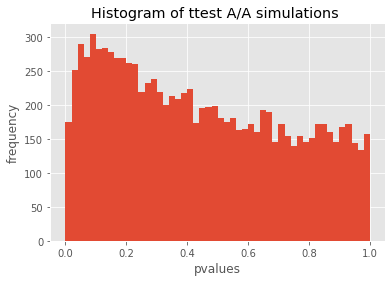

уровень FPR: 0.0559


In [75]:
aa_simulations(united_df)

  0%|          | 0/10000 [00:00<?, ?it/s]

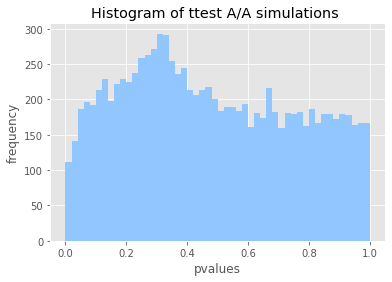

уровень FPR: 0.0331


In [76]:
aa_simulations(united_df.groupby(['uid', 'group_id'], as_index=False)\
            .agg({'total_revenue': 'first'}), column_name = 'total_revenue')

Видим на boxplot этот странный показатель, который может влиять не только на A/A-тест, но и, разумеется, на A/B. Так как показатель total_revenue почти в 4 раза выше самого большое показателя в тестовой группе, и почти в 6 - в контрольной 2.  
Причем судя по его чекам, только за первый час он купил 16 раз на общую сумму более 150К. Выглядит это очень странно. Либо это ошибка, либо бот, либо просто ненормальный, по поведению которого вряд ли стоит делать выводы об общих тенденциях. На основании этого принимаем решение исключить перед дальнейшим исследованием.

In [77]:
px.box(united_df, x = 'total_revenue', **plot_config)

In [78]:
rich_guy = united_df[united_df['total_revenue'] == united_df['total_revenue'].max()].uid.unique()
px.histogram(united_df[united_df['uid'] == rich_guy[0]], x = 'paid_at', y = 'revenue', nbins=100, **plot_config)

In [79]:
united_df = united_df[united_df['uid'] != rich_guy[0]]

Повторим AA-тест. Стало лучше! Будем считать, что система сплитования работает корректно. Продолжим исследование.

  0%|          | 0/10000 [00:00<?, ?it/s]

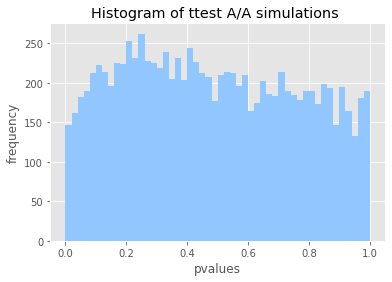

уровень FPR: 0.0396


In [80]:
aa_simulations(united_df)

  0%|          | 0/10000 [00:00<?, ?it/s]

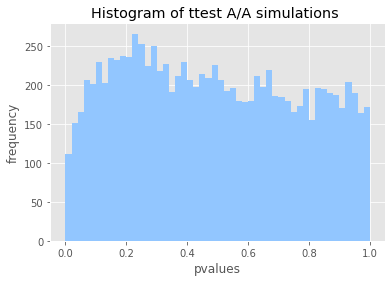

уровень FPR: 0.0342


In [81]:
aa_simulations(united_df.groupby(['uid', 'group_id'], as_index=False)\
            .agg({'total_revenue': 'first'}), column_name='total_revenue')

In [82]:
px.box(united_df[united_df['total_revenue'] > 0 ], x = 'total_revenue', **plot_config)

In [83]:
#добавим показатели среднего чека и повторных покупок
united_df['avg_check'] = united_df['revenue'].groupby(united_df['uid']).transform('mean')
united_df['apc'] = united_df['paid_at'].groupby(united_df['uid']).transform('count')
united_df.head()

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type,group_id,only_start_date,diff_to_pay,start_date_joined,start_date_paid,avg_check,apc
5,891497961,28,400,28.0,Chile,"1,2",1,25,31,25,0.0,0.0,6396.0,Chile,2017-11-02 15:07:00,2017-11-02 17:16:00,2418.0,67.0,gifts,other_type,cntr1,2017-02-11,0 days 02:09:00,2017-11-02,2017-11-02,3198.0,2
6,891497961,28,400,28.0,Chile,"1,2",1,25,31,25,0.0,0.0,6396.0,Chile,2017-11-02 15:07:00,2017-11-04 02:25:00,3978.0,146.0,empty_likes,coins,cntr1,2017-02-11,1 days 11:18:00,2017-11-02,2017-11-04,3198.0,2
175,891292845,22,0,NaN,Italy,nan,1,19,40,0,1.0,1.0,1898.0,Italy,2017-11-06 03:51:00,2017-11-06 03:59:00,1898.0,68.0,none,premium_no_trial,cntr1,2017-06-11,0 days 00:08:00,2017-11-06,2017-11-06,1898.0,1
188,891264903,19,239,NaN,United States of America,"2,3,4,5,6,7,8,9",1,16,22,46,1.0,1.0,7761.0,United States of America,2017-11-06 16:02:00,2017-11-08 22:32:00,3887.0,147.0,none,premium_no_trial,cntr1,2017-06-11,2 days 06:30:00,2017-11-06,2017-11-08,3880.5,2
189,891264903,19,239,NaN,United States of America,"2,3,4,5,6,7,8,9",1,16,22,46,1.0,1.0,7761.0,United States of America,2017-11-06 16:02:00,2017-11-09 10:32:00,3874.0,147.0,none,premium_no_trial,cntr1,2017-06-11,2 days 18:30:00,2017-11-06,2017-11-09,3880.5,2


Для удобства работы с показателями total_revenue, avg_check и проч введем новую переменную unique_df. А/a тест по средним чекам тоже хороший. 

In [84]:
unique_df = united_df.drop_duplicates('uid')

  0%|          | 0/10000 [00:00<?, ?it/s]

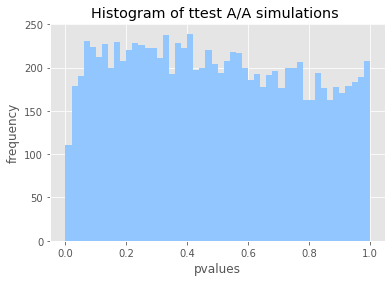

уровень FPR: 0.0371


In [85]:
aa_simulations(unique_df, column_name='avg_check')

  0%|          | 0/10000 [00:00<?, ?it/s]

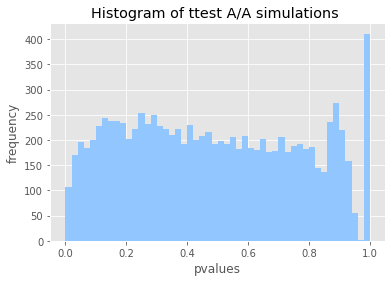

уровень FPR: 0.0351


In [86]:
aa_simulations(unique_df, column_name='apc')

_______________

### Метрики продукта

**Users** - сколько всего пользователей у продукта \
**Buyers** - Количество покупателей \
**С1** - конверсия в покупателя\
**С2** - конверсия в премиум подписку\
**Orders** - количество заказов \
**APC** - повторные покупки (Average Payment Count) \
**all_revenue** - доход по всем пользователям за период \
**ARPPU** - средний доход на платящего клиента (Average revenue per paying user)\
**ARPU** - средний доход на привлеченного пользователя (Average revenue per user)\

In [87]:
def metrics(data):
    """**Users** - сколько всего пользователей у продукта \
        **Buyers** - Количество покупателей \
        **С1** - конверсия в покупателя\
        **С2** - конверсия в премиум подписку\
        **Orders** - количество заказов \
        **APC** - повторные покупки (Average Payment Count) \
        **all_revenue** - доход по всем пользователям за период \
        **ARPPU** - средний доход на платящего клиента (Average revenue per paying user)\
        **ARPU** - средний доход на привлеченного пользователя (Average revenue per user)"""
    
    all_result = data.groupby('group_id')\
            .agg({'uid': 'nunique'})
    buyers_df = data.query('total_revenue > 0') #оставляем только покупателей, то есть тех, у кого total_revenue > 0
    buyers_result = buyers_df.groupby('group_id')\
            .agg({'uid': 'nunique'})
    results = buyers_result.merge(all_result, on = 'group_id')\
            .rename(columns={'uid_x': 'buyers', 'uid_y': 'users'})
    results['с1'] = round(results['buyers']/results['users'],3)

    #считаем количество новых покупателей премиум-подписок за период
    c2_result = data.query('product_type == "premium_no_trial" or product_type == "trial_premium"')\
            .groupby(['group_id'])\
            .agg({'uid': 'nunique'})\
            .rename(columns={'uid' : 'bought_premium'})


    results = results.merge(c2_result, on = 'group_id')
    results['c2'] = round(results['bought_premium']/results['users'], 3) #считаем саму конверсию С2

    orders = data.groupby('group_id')\
                    .agg({'paid_at': 'count'})\
                    .rename(columns={'paid_at' : 'orders'})
    results = results.merge(orders, on='group_id')

    results['apc'] = round(results['orders']/results['buyers'], 3)

    #считаем по revenue, потому что в некоторых значения total_revenue есть ошибки
    all_revenue = data.groupby('group_id')\
                    .agg({'revenue': 'sum'})\
                    .rename(columns={'revenue' : 'all_revenue'})
    results = results.merge(all_revenue, on='group_id')
    results['avprice'] = results['all_revenue']/results['orders']

    results['arppu'] = results['apc']*results['avprice']
    results['arpu'] = results['arppu']*results['с1']
    
    avpremium = data.query('product_type == "premium_no_trial"')\
            .groupby(['group_id'])\
            .agg({'revenue': 'median'})\
            .rename(columns={'revenue' : 'avgpremium'})
    results = results.merge(avpremium, on='group_id')
    
    return results

In [88]:
metrics(united_df)

,buyers,users,с1,bought_premium,c2,orders,apc,all_revenue,avprice,arppu,arpu,avgpremium
group_id,,,,,,,,,,,,
cntr1,190,4338,0.044,165,0.038,347,1.826,2125175.0,6124.423631,11183.197550,492.060692,6292.0
cntr2,187,4264,0.044,155,0.036,328,1.754,1920438.0,5854.993902,10269.659305,451.865009,6292.0
test,146,4308,0.034,127,0.029,273,1.870,2344901.0,8589.380952,16062.142381,546.112841,8021.0


#### Какие выводы мы можем из этого первичного анализа датасета?
        
Несмотря на примерно одинаковые группы по количеству пользователей, мы видим заметную разницу:
   
   - в конверсии в покупателя (C1) - ниже, чем в контрольных группах;
   - в конверсии в премиум-подписчика (C2) - ниже, чем в контрольных группах;
   - а также в среднем чеке (avprice) - он выше;
   - средний доход на платящего клиента (arppu) -  выше;
   - средняя цена премиум - выше;
   
Но самое главное! 
   - повторные покупки не изменились;
   - средний чек подрос;
   - **средний доход с привлеченного пользователя выше (arpu)**, чем в контрольной группе!
   
То есть предварительно мы можем сказать, что эксперимент удачен. В конечном итоге, даже с некоторыми потерями на этапе конверсии в покупателя, нововведение в виде повышения цены подписки, имеет смысл - оно **приносит прибыль**.

Но это выводы сделанные на глаз, хотелось бы быть более уверенными в своих выводах. Поэтому далее мы проведем ряд статистических тестов, чтобы убедиться, что различия значимы. И попробоем поискать, можно ли как-то еще больше усилить этот эффект? 

___________________

### Метрики аудитории

In [89]:
#Для удобства преобразуем колонку visit_days в visits_sum (суммарное количество посещенных дней)
united_df['visits_sum'] = united_df.visit_days.apply(lambda x: len(list(str(x).split(','))) if x != 'nan' else 0)

In [90]:
px.histogram(united_df, x = 'visits_sum', **plot_config)

In [91]:
#Создаем колонку с количеством прошедших с последнего визита дней. Так как была проблема с появлением 60, 120, 150, я решила оставить только дни не более 30 для проведения rfm анализа
def extract_last_day(x):
    x_list = [int(i) for i in x.split(',')] #1,2,3 -> [1, 2, 3]
    x_list = [i for i in x_list if i <= 30]
    if len(x_list) == 0:
        return 0
    else:
        return max(x_list)

united_df['last_day'] = united_df['visit_days'].apply(lambda x: extract_last_day(x) if x != 'nan' else 0)
united_df['recent_date'] =  united_df['joined_at'] + pd.to_timedelta(united_df['last_day'], unit='d')
united_df['since_recent_visit'] = ((united_df['paid_at'].max() + pd.to_timedelta(1, unit='d')) - united_df['recent_date']).dt.days

#Такое распределение дней с последнего визита. Выглядит очень реалистично
px.histogram(united_df, x = 'since_recent_visit', **plot_config)

______

## Статистические тесты 

Для статистической оценки значимости различий средних можно было бы использовать метод Манна Уитни. \
Так как наши данные **НЕ** распределены нормальным образом и имеют **выбросы**, которые могут сказаться на результатах теста. Но так как его сложнее интерпретировать и мы не можем с точностью сказать, где именно имеются различия, воспользуемся бутстрепом. 

In [92]:
def test_mannwhitneyu(data, control = 'cntr1'):
    '''test Mann Whitneyu'''
    data_revenue = data.groupby(['uid', 'group_id'], as_index=False)\
            .agg({'revenue':'sum'})
    
    cntr = data_revenue[data_revenue['group_id'] == control]
    test = data_revenue[data_revenue['group_id'] == 'test']
    
    if int(test.revenue.count()) < 5:
            return 'Маленькая выборка'
    
    else: 
        mannwh = mannwhitneyu(cntr.revenue, test.revenue)
        return mannwh

In [93]:
#У нас есть все основания для отвержения H0 о равенстве выборок с уровнем значимости ~ 0.02. 
print(test_mannwhitneyu(united_df))
print(test_mannwhitneyu(united_df, control='cntr2'))

MannwhitneyuResult(statistic=9435565.5, pvalue=0.018680468737135632)
MannwhitneyuResult(statistic=9272347.5, pvalue=0.022221876167364648)


In [94]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append((statistic(samples_1))-(statistic(samples_2))) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

Бутстреп нам не позволяет отвергнуть нулевую гипотезу о равенстве средних чеков. Предполагаем, что такая картина из-за большого количества нулевых чеков.

  0%|          | 0/10000 [00:00<?, ?it/s]

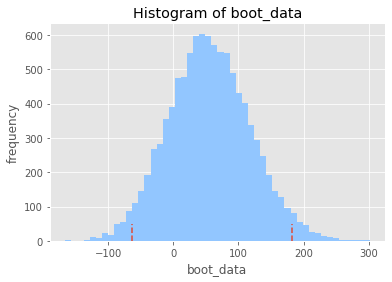

p_value: 0.37435510248596005, 
 доверительный интервал:                0
0.025  -63.077192
0.975  182.056553


  0%|          | 0/10000 [00:00<?, ?it/s]

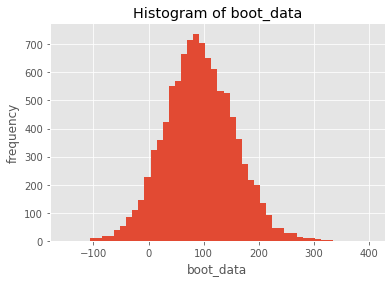

p_value: 0.13915845769633062, 
 доверительный интервал:                0
0.025  -28.139797
0.975  217.391950


In [95]:
booted_data_1 = get_bootstrap(united_df[united_df['group_id'] == 'test'].revenue, 
                             united_df[united_df['group_id'] == 'cntr1'].revenue, 
             statistic = np.mean)
print(f'''p_value: {booted_data_1["p_value"]}, \n доверительный интервал:{booted_data_1["ci"]}''')

booted_data_2 = get_bootstrap(united_df[united_df['group_id'] == 'test'].revenue, 
                             united_df[united_df['group_id'] == 'cntr2'].revenue, 
             statistic = np.mean)
print(f'''p_value: {booted_data_2["p_value"]}, \n доверительный интервал:{booted_data_2["ci"]}''')

Поэтому повторяем бутстреп на чеках только платящих пользователей (которые совершили хотя бы одну операцию). Мы видим значимые различия по всем показателям: revenue (чеки), total_revenue (общая выручка на пользователя) и avg_check (средний чек)

In [97]:
#Создадим таблицу с платящими пользователями
paid_df = united_df[~united_df['paid_at'].isna()]

  0%|          | 0/10000 [00:00<?, ?it/s]

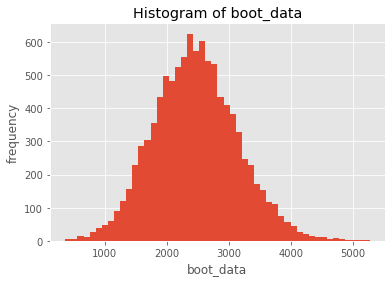

p_value for comparing with cntr1: 0.00026703906029076544, 
 доверительный интервал:                 0
0.025  1198.484798
0.975  3849.339337


  0%|          | 0/10000 [00:00<?, ?it/s]

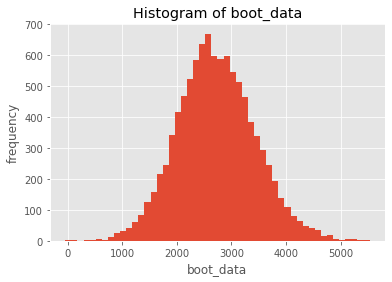

p_value for comparing with cntr2: 0.00014107166037685137, 
 доверительный интервал:                 0
0.025  1372.223323
0.975  4203.525229


In [98]:
booted_data_1 = get_bootstrap(paid_df[paid_df['group_id'] == 'test'].revenue, 
                             paid_df[paid_df['group_id'] == 'cntr1'].revenue, 
             statistic = np.mean)
print(f'''p_value for comparing with cntr1: {booted_data_1["p_value"]}, \n доверительный интервал:{booted_data_1["ci"]}''')

booted_data_2 = get_bootstrap(paid_df[paid_df['group_id'] == 'test'].revenue, 
                             paid_df[paid_df['group_id'] == 'cntr2'].revenue, 
             statistic = np.mean)
print(f'''p_value for comparing with cntr2: {booted_data_2["p_value"]}, \n доверительный интервал:{booted_data_2["ci"]}''')

In [99]:
unique_paid = paid_df.drop_duplicates('uid') #объявим новую переменную - только уникальные значения Total_revenue и проч, и только для платящих пользователей

  0%|          | 0/10000 [00:00<?, ?it/s]

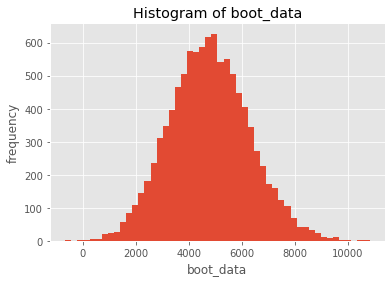

p_value for comparing with cntr1: 0.001489580197866963, 
 доверительный интервал:                 0
0.025  1930.426832
0.975  7831.688351


  0%|          | 0/10000 [00:00<?, ?it/s]

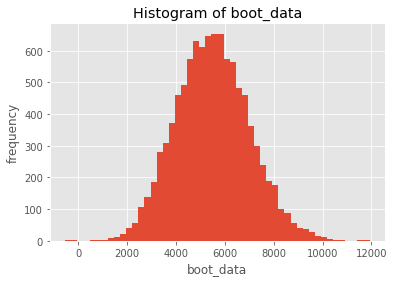

p_value for comparing with cntr2: 0.0002589250317290274, 
 доверительный интервал:                 0
0.025  2691.305882
0.975  8564.667647


In [100]:
booted_data_1 = get_bootstrap(unique_paid[(unique_paid['group_id'] == 'test')].total_revenue, 
                             unique_paid[(unique_paid['group_id'] == 'cntr1')].total_revenue, 
             statistic = np.mean)
print(f'''p_value for comparing with cntr1: {booted_data_1["p_value"]}, \n доверительный интервал:{booted_data_1["ci"]}''')

booted_data_2 = get_bootstrap(unique_paid[(unique_paid['group_id'] == 'test')].total_revenue, 
                             unique_paid[(unique_paid['group_id'] == 'cntr2')].total_revenue, 
             statistic = np.mean)
print(f'''p_value for comparing with cntr2: {booted_data_2["p_value"]}, \n доверительный интервал:{booted_data_2["ci"]}''')

  0%|          | 0/10000 [00:00<?, ?it/s]

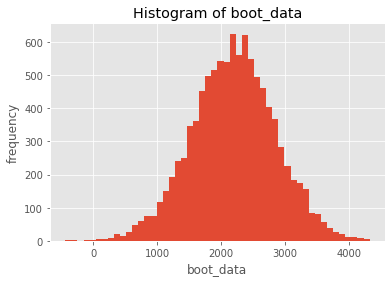

p_value for comparing with cntr1: 0.0007919619327717459, 
 доверительный интервал:                 0
0.025   872.938600
0.975  3478.119726


  0%|          | 0/10000 [00:00<?, ?it/s]

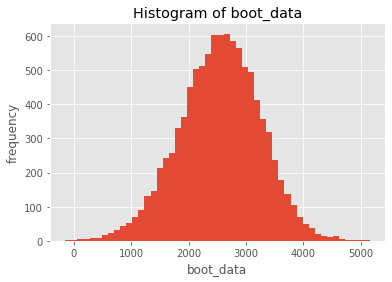

p_value for comparing with cntr2: 0.0003127651377633679, 
 доверительный интервал:                 0
0.025  1097.597724
0.975  3854.155490


In [101]:
booted_data_1 = get_bootstrap(unique_paid[(unique_paid['group_id'] == 'test')].avg_check, 
                             unique_paid[(unique_paid['group_id'] == 'cntr1')].avg_check, 
             statistic = np.mean)
print(f'''p_value for comparing with cntr1: {booted_data_1["p_value"]}, \n доверительный интервал:{booted_data_1["ci"]}''')

booted_data_2 = get_bootstrap(unique_paid[(unique_paid['group_id'] == 'test')].avg_check, 
                             unique_paid[(unique_paid['group_id'] == 'cntr2')].avg_check, 
             statistic = np.mean)
print(f'''p_value for comparing with cntr2: {booted_data_2["p_value"]}, \n доверительный интервал:{booted_data_2["ci"]}''')

Вывод: нововведение в целом имеет смысл, оно значимо увеличивает средний чек на 1200 - 4200 среди платящих пользователей! 

_______________

### Исследование отдельных сегментов

Есть ли какое-то особое влияние изменения на отдельные сегменты пользователей?  
Проверим следующие гипотезы, что нет значимых различий в средних чеках:

                    1. среди "лояльных" и нет (was_premium и др);  
                    2. среди разных возрастов;
                    3. в разных странах;
                    4. по интенсивности использования приложения

#### 1. Лояльные
Начнем с самого очевидного, лояльные меньше подвержены оттоку, что мы видим в том числе по неизменившимся показателям повторных покупок, например. \
Бутсрап нам это только подтверждает: средний чек увеличивается от 1225 до 4294 в тестовой группе (для wasn't premium бутстреп не дает однозначный результат)  

  0%|          | 0/10000 [00:00<?, ?it/s]

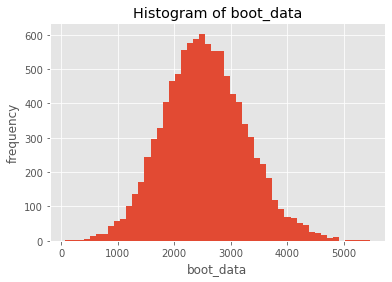

p_value for comparing with cntr1: 0.00048779199400007263, 
 доверительный интервал:                 0
0.025  1171.451803
0.975  4066.738245


  0%|          | 0/10000 [00:00<?, ?it/s]

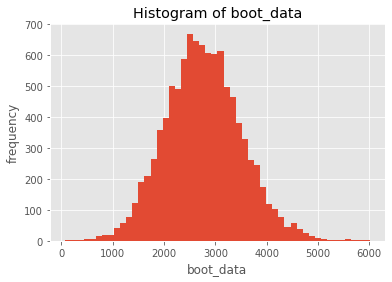

p_value for comparing with cntr2: 0.00018162797113617217, 
 доверительный интервал:                 0
0.025  1388.985417
0.975  4274.977083


In [102]:
booted_data_1 = get_bootstrap(paid_df[(paid_df['was_premium'] != 0) &
                                   (paid_df['group_id'] == 'test')].revenue, 
                             paid_df[(paid_df['was_premium'] != 0) &
                                   (paid_df['group_id'] == 'cntr1')].revenue, 
             statistic = np.mean)
print(f'''p_value for comparing with cntr1: {booted_data_1["p_value"]}, \n доверительный интервал:{booted_data_1["ci"]}''')

booted_data_2 = get_bootstrap(paid_df[(paid_df['was_premium'] != 0) &
                                   (paid_df['group_id'] == 'test')].revenue, 
                             paid_df[(paid_df['was_premium'] != 0) &
                                   (paid_df['group_id'] == 'cntr2')].revenue, 
             statistic = np.mean)
print(f'''p_value for comparing with cntr2: {booted_data_2["p_value"]}, \n доверительный интервал:{booted_data_2["ci"]}''')

In [104]:
#Манна-Уитни тест говорит о том же. Повышать подписку для лояльных стоит.
was_premium = paid_df[(paid_df['was_premium'] == 1)]
wasnt_premium = paid_df[(paid_df['was_premium'] == 0)]
print(test_mannwhitneyu(was_premium))
print(test_mannwhitneyu(wasnt_premium))

MannwhitneyuResult(statistic=9232.5, pvalue=7.294848026360222e-05)
MannwhitneyuResult(statistic=62.0, pvalue=0.04796002957861997)


#### 2. Возраст

In [107]:
#Чтобы не брать возраст пальцем в небо, воспользуемся квантилями, но сперва посмотрим на распределение. Почти красивое! 
px.histogram(paid_df, x = 'age', **plot_config)

In [108]:
age_clast = unique_paid.age.quantile([.25, .5, .75]).to_list()
age_clast

[25.0, 30.0, 38.0]

In [109]:
yongest = paid_df[(paid_df['age'] < age_clast[0])]
print(test_mannwhitneyu(yongest))
normal = paid_df[(paid_df['age'] > age_clast[0]) &
                 (paid_df['age'] < age_clast[1])]
print(test_mannwhitneyu(normal))
normal_2 = paid_df[(paid_df['age'] > age_clast[1]) &
                 (paid_df['age'] < age_clast[2])]
print(test_mannwhitneyu(normal_2))
eldest = paid_df[(paid_df['age'] > age_clast[2]) &
                 (paid_df['age'] < 90)] #очевидно кто-то пошутил насчет 98-99 лет. Мы видим на гистограмме это явно (выбросы). Поэтому исключим их из теста, чтобы не портили картину.
print(test_mannwhitneyu(eldest))

MannwhitneyuResult(statistic=445.0, pvalue=0.013019905274851919)
MannwhitneyuResult(statistic=245.5, pvalue=0.02240281828454139)
MannwhitneyuResult(statistic=520.5, pvalue=0.025007857378762585)
MannwhitneyuResult(statistic=598.0, pvalue=0.522340963059341)


In [110]:
px.box(yongest, x= 'revenue', **plot_config)

Манна Уитни нам показал для всех групп, кроме пользователей старшего возраста: старше 38 лет. 
Бутстрап не показывает те же самые различия в средних чеках между группами, поскольку мы видим выбросы в контрольной группе 1. Мы не можем просто так выбросить их, поскольку они не выглядят подозрительно. Лучше используем здесь для сравнения разницу медиан.

  0%|          | 0/10000 [00:00<?, ?it/s]

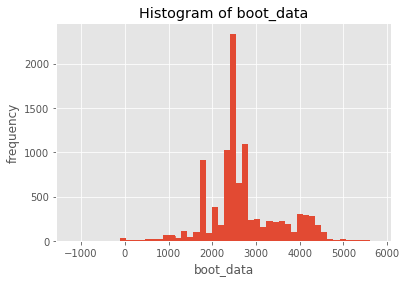

p_value for comparing with cntr1: 0.0009808134153622603, 
 доверительный интервал:               0
0.025  1150.3375
0.975  4407.0000


  0%|          | 0/10000 [00:00<?, ?it/s]

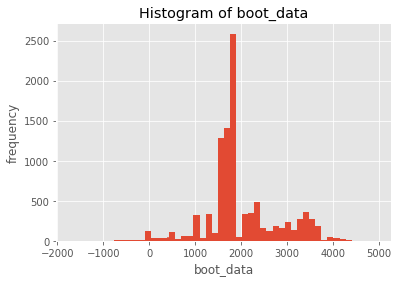

p_value for comparing with cntr2: 0.011388434464926362, 
 доверительный интервал:               0
0.025   396.0125
0.975  3653.0000


In [111]:
booted_data_1 = get_bootstrap(yongest[yongest['group_id'] == 'test'].revenue, 
                             yongest[(yongest['group_id'] == 'cntr1')].revenue, 
             statistic = np.median)
print(f'''p_value for comparing with cntr1: {booted_data_1["p_value"]}, \n доверительный интервал:{booted_data_1["ci"]}''')

booted_data_2 = get_bootstrap(yongest[yongest['group_id'] == 'test'].revenue, 
                             yongest[(yongest['group_id'] == 'cntr2')].revenue, 
             statistic = np.median)
print(f'''p_value for comparing with cntr2: {booted_data_2["p_value"]}, \n доверительный интервал:{booted_data_2["ci"]}''')

Возраст 25-30 лет 

In [112]:
px.box(normal, x= 'revenue', **plot_config)

  0%|          | 0/10000 [00:00<?, ?it/s]

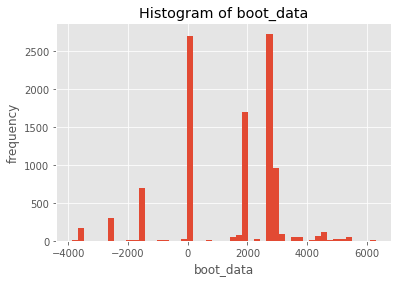

p_value for comparing with cntr1: 0.4552790377550837, 
 доверительный интервал:            0
0.025 -2509.0
0.975  4368.0


  0%|          | 0/10000 [00:00<?, ?it/s]

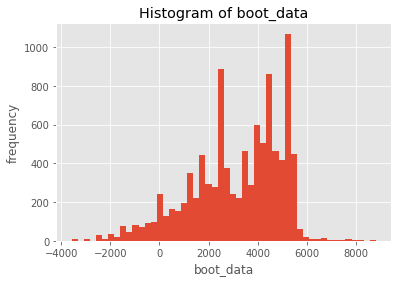

p_value for comparing with cntr2: 0.09037290390124014, 
 доверительный интервал:               0
0.025 -1027.0000
0.975  5466.6625


In [113]:
booted_data_1 = get_bootstrap(normal[normal['group_id'] == 'test'].revenue, 
                             normal[(normal['group_id'] == 'cntr1')].revenue, 
             statistic = np.median)
print(f'''p_value for comparing with cntr1: {booted_data_1["p_value"]}, \n доверительный интервал:{booted_data_1["ci"]}''')

booted_data_2 = get_bootstrap(normal[normal['group_id'] == 'test'].revenue, 
                             normal[(normal['group_id'] == 'cntr2')].revenue, 
             statistic = np.median)
print(f'''p_value for comparing with cntr2: {booted_data_2["p_value"]}, \n доверительный интервал:{booted_data_2["ci"]}''')

Возраст 30-38 лет

In [114]:
px.box(normal_2, x='revenue', **plot_config)

  0%|          | 0/10000 [00:00<?, ?it/s]

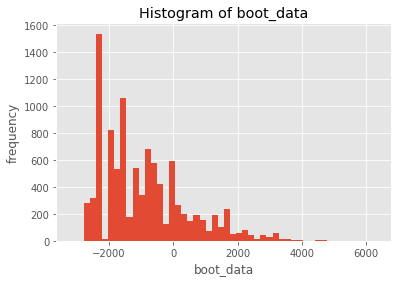

p_value for comparing with cntr1: 0.49393207589076804, 
 доверительный интервал:            0
0.025 -2678.0
0.975  2314.0


  0%|          | 0/10000 [00:00<?, ?it/s]

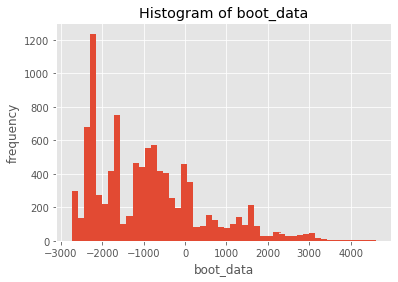

p_value for comparing with cntr2: 0.4954700840294951, 
 доверительный интервал:               0
0.025 -2678.0000
0.975  2294.6625


In [115]:
booted_data_1 = get_bootstrap(normal_2[normal_2['group_id'] == 'test'].revenue, 
                             normal_2[(normal_2['group_id'] == 'cntr1')].revenue, 
             statistic = np.median)
print(f'''p_value for comparing with cntr1: {booted_data_1["p_value"]}, \n доверительный интервал:{booted_data_1["ci"]}''')

booted_data_2 = get_bootstrap(normal_2[normal_2['group_id'] == 'test'].revenue, 
                             normal_2[(normal_2['group_id'] == 'cntr2')].revenue, 
             statistic = np.median)
print(f'''p_value for comparing with cntr2: {booted_data_2["p_value"]}, \n доверительный интервал:{booted_data_2["ci"]}''')

Старше 38 лет 

In [116]:
px.box(eldest, x='revenue', **plot_config)

  0%|          | 0/10000 [00:00<?, ?it/s]

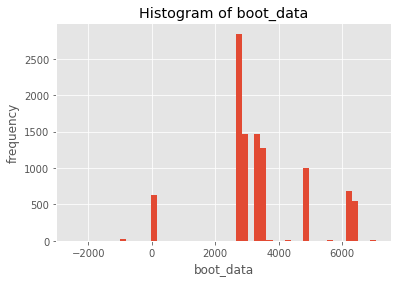

p_value for comparing with cntr1: 0.019604463519351058, 
 доверительный интервал:            0
0.025     0.0
0.975  6305.0


  0%|          | 0/10000 [00:00<?, ?it/s]

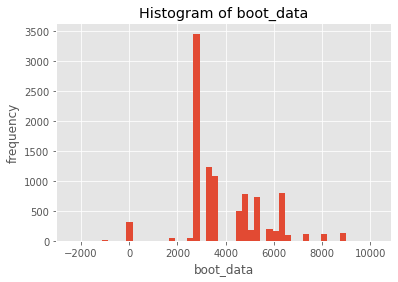

p_value for comparing with cntr2: 0.013646445910465436, 
 доверительный интервал:            0
0.025    13.0
0.975  7332.0


In [117]:
booted_data_1 = get_bootstrap(eldest[eldest['group_id'] == 'test'].revenue, 
                             eldest[(eldest['group_id'] == 'cntr1')].revenue, 
             statistic = np.median)
print(f'''p_value for comparing with cntr1: {booted_data_1["p_value"]}, \n доверительный интервал:{booted_data_1["ci"]}''')

booted_data_2 = get_bootstrap(eldest[eldest['group_id'] == 'test'].revenue, 
                             eldest[(eldest['group_id'] == 'cntr2')].revenue, 
             statistic = np.median)
print(f'''p_value for comparing with cntr2: {booted_data_2["p_value"]}, \n доверительный интервал:{booted_data_2["ci"]}''')

In [118]:
metrics(eldest)

,buyers,users,с1,bought_premium,c2,orders,apc,all_revenue,avprice,arppu,arpu,avgpremium
group_id,,,,,,,,,,,,
cntr1,40,41,0.976,36,0.878,71,1.775,499473.0,7034.830986,12486.825000,12187.141200,6292.0
cntr2,46,46,1.000,38,0.826,87,1.891,520715.0,5985.229885,11318.069713,11318.069713,6292.0
test,32,32,1.000,25,0.781,44,1.375,499382.0,11349.590909,15605.687500,15605.687500,11115.0


In [119]:
metrics(yongest)

,buyers,users,с1,bought_premium,c2,orders,apc,all_revenue,avprice,arppu,arpu,avgpremium
group_id,,,,,,,,,,,,
cntr1,45,45,1.0,39,0.867,84,1.867,542061.0,6453.107143,12047.951036,12047.951036,6292.0
cntr2,51,51,1.0,40,0.784,78,1.529,398814.0,5113.000000,7817.777000,7817.777000,6292.0
test,30,30,1.0,29,0.967,65,2.167,499915.0,7691.000000,16666.397000,16666.397000,8190.0


Вывод: есть статистически значимое различие в медианных чеках между контрольными и тестовыми группами среди пользователей до 25 и старше 38.  

#### 3. Страны
Для проверки стран я взяла страны, где значений платящих users хотя бы 20. Из них можно отвергнуть H0 о равенстве средних можно лишь в 2 случаях:
    
   - United States of America,
   - **Italy**,
   - France,
   - Spain,
   - United Kingdom (Great Britain),
   - Israel,
   - **Argentina**,
   - Chile,
   - Canada,
   - United Arab Emirates
   
Однако это не значит, что для других стран вообще нет различий, возможно, стоит продолжить эксперимент, чтобы набрать больше наьлюдений. 

In [120]:
paid_dict = paid_df.groupby('uid', as_index=False).agg({'country_x': 'first'})\
                    .country_x.value_counts().to_dict()
paid_dict = [x for x in paid_dict if paid_dict[x] >= 20]
paid_dict

['United States of America',
 'France',
 'Italy',
 'Spain',
 'Argentina',
 'United Kingdom (Great Britain)',
 'Israel',
 'Chile',
 'United Arab Emirates']

In [121]:
american = paid_df[paid_df['country_x'] == 'United States of America']

french = paid_df[paid_df['country_x'] == 'France']

israel = paid_df[paid_df['country_x'] == 'Israel']

italy = paid_df[paid_df['country_x'] == 'Italy']

spain = paid_df[paid_df['country_x'] == 'Spain']

argentins = paid_df[paid_df['country_x'] == 'Argentina']

arab = paid_df[paid_df['country_x'] == 'United Arab Emirates']

englishman = paid_df[paid_df['country_x'] == 'United Kingdom (Great Britain)']

nations = [american, french, israel, italy, spain, argentins, arab, englishman]

In [122]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

Для сравнения с сntr1 есть различия средних с french, italy, argentins \
для cntr2 есть различия средних для americans, izrael, italy, argentins.

Для обоих только italy, argentins

  0%|          | 0/10000 [00:00<?, ?it/s]

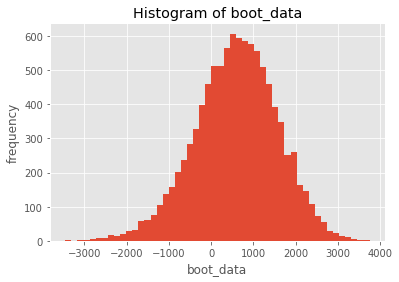

p_value for american with comparing cntr1: 0.541045995007293, 
 доверительный интервал:                 0
0.025 -1438.369524
0.975  2398.366905


  0%|          | 0/10000 [00:00<?, ?it/s]

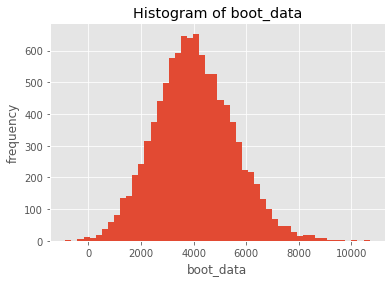

p_value for french with comparing cntr1: 0.00651973298013157, 
 доверительный интервал:                 0
0.025  1271.308333
0.975  7046.341667


  0%|          | 0/10000 [00:00<?, ?it/s]

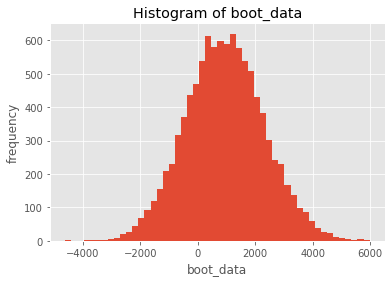

p_value for israel with comparing cntr1: 0.4911562408715805, 
 доверительный интервал:                 0
0.025 -1694.801136
0.975  3696.771591


  0%|          | 0/10000 [00:00<?, ?it/s]

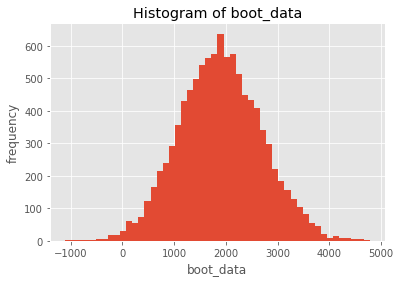

p_value for italy with comparing cntr1: 0.016894308620552623, 
 доверительный интервал:                 0
0.025   387.991667
0.975  3489.008333


  0%|          | 0/10000 [00:00<?, ?it/s]

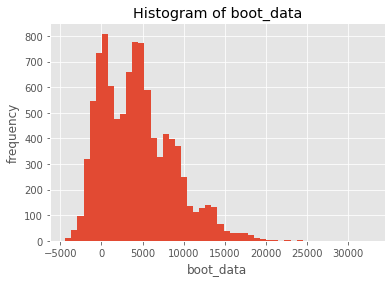

p_value for spain with comparing cntr1: 0.3192458407938994, 
 доверительный интервал:               0
0.025  -1900.691
0.975  14135.745


  0%|          | 0/10000 [00:00<?, ?it/s]

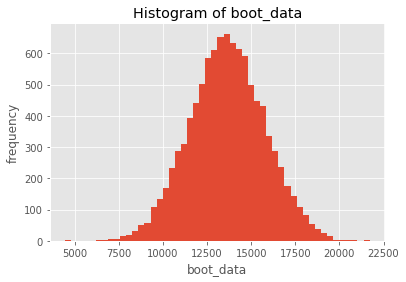

p_value for argentins with comparing cntr1: 1.2922550754679883e-10, 
 доверительный интервал:                  0
0.025   9495.432143
0.975  17830.521429


  0%|          | 0/10000 [00:00<?, ?it/s]

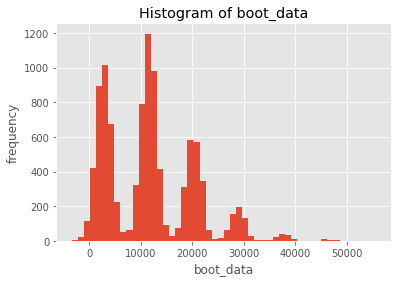

p_value for arab with comparing cntr1: 0.16866689920836142, 
 доверительный интервал:                  0
0.025    591.472917
0.975  30244.716667


  0%|          | 0/10000 [00:00<?, ?it/s]

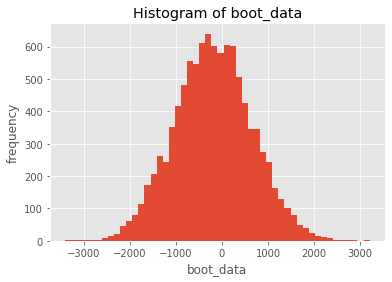

p_value for englishman with comparing cntr1: 0.8206272308985226, 
 доверительный интервал:                 0
0.025 -1811.777500
0.975  1456.920833


In [123]:
#разница средних по странам в сравнении с контрольной группой 1 
for nation in nations:
    booted_data = get_bootstrap(nation[nation['group_id'] == 'test'].revenue, 
                                nation[nation['group_id'] == 'cntr1'].revenue, 
                                statistic = np.mean)
    print(f'''p_value for {get_df_name(nation)} with comparing cntr1: {booted_data["p_value"]}, \n доверительный интервал:{booted_data["ci"]}''')

  0%|          | 0/10000 [00:00<?, ?it/s]

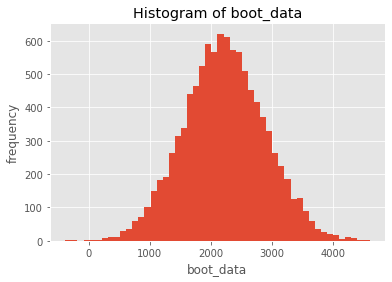

p_value for american with comparing cntr1: 0.0008158579239555452, 
 доверительный интервал:                 0
0.025   938.764019
0.975  3527.276636


  0%|          | 0/10000 [00:00<?, ?it/s]

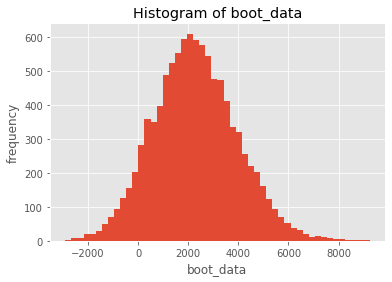

p_value for french with comparing cntr1: 0.16978120465916768, 
 доверительный интервал:                 0
0.025  -840.469118
0.975  5639.725000


  0%|          | 0/10000 [00:00<?, ?it/s]

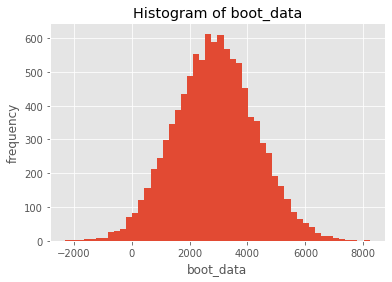

p_value for israel with comparing cntr1: 0.03954512557412846, 
 доверительный интервал:                0
0.025   191.73375
0.975  5647.91500


  0%|          | 0/10000 [00:00<?, ?it/s]

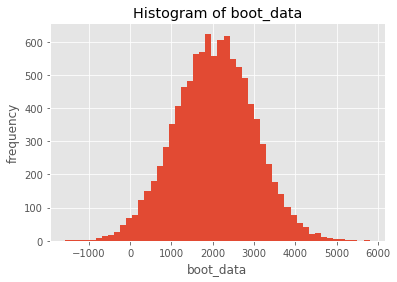

p_value for italy with comparing cntr1: 0.03141106326905819, 
 доверительный интервал:                 0
0.025   161.889394
0.975  3885.443939


  0%|          | 0/10000 [00:00<?, ?it/s]

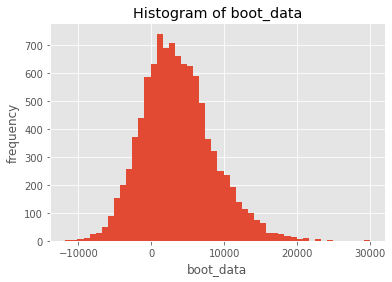

p_value for spain with comparing cntr1: 0.4560916885318239, 
 доверительный интервал:               0
0.025  -4906.525
0.975  14355.198


  0%|          | 0/10000 [00:00<?, ?it/s]

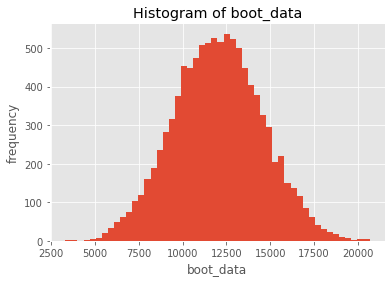

p_value for argentins with comparing cntr1: 1.944120102058597e-06, 
 доверительный интервал:                  0
0.025   7103.561111
0.975  16967.166667


  0%|          | 0/10000 [00:00<?, ?it/s]

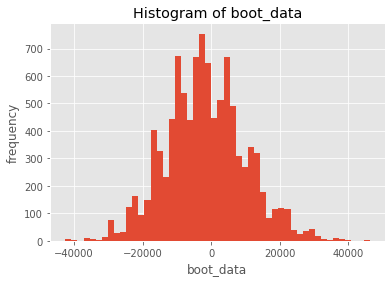

p_value for arab with comparing cntr1: 0.8857338533560396, 
 доверительный интервал:               0
0.025 -23363.275
0.975  22314.500


  0%|          | 0/10000 [00:00<?, ?it/s]

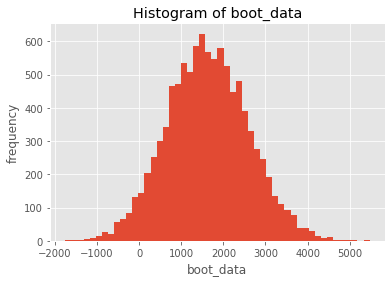

p_value for englishman with comparing cntr1: 0.09095911835484309, 
 доверительный интервал:                0
0.025  -217.14875
0.975  3552.93250


In [124]:
#разница средних по странам в сравнении с контрольной группой 2
for nation in nations:
    booted_data = get_bootstrap(nation[nation['group_id'] == 'test'].revenue, 
                                nation[nation['group_id'] == 'cntr2'].revenue, 
                                statistic = np.mean)
    print(f'''p_value for {get_df_name(nation)} with comparing cntr1: {booted_data["p_value"]}, \n доверительный интервал:{booted_data["ci"]}''')

In [125]:
metrics(argentins)

,buyers,users,с1,bought_premium,c2,orders,apc,all_revenue,avprice,arppu,arpu,avgpremium
group_id,,,,,,,,,,,,
cntr1,12,12,1.0,12,1.000,28,2.333,144690.0,5167.500000,12055.7775,12055.7775,6292.0
cntr2,10,10,1.0,9,0.900,18,1.800,121017.0,6723.166667,12101.7000,12101.7000,6292.0
test,7,7,1.0,6,0.857,10,1.429,188019.0,18801.900000,26867.9151,26867.9151,12597.0


In [126]:
metrics(italy)

,buyers,users,с1,bought_premium,c2,orders,apc,all_revenue,avprice,arppu,arpu,avgpremium
group_id,,,,,,,,,,,,
cntr1,16,16,1.0,13,0.812,39,2.438,147368.0,3778.666667,9212.389333,9212.389333,6292.0
cntr2,16,16,1.0,6,0.375,33,2.062,118989.0,3605.727273,7435.009636,7435.009636,6396.0
test,9,9,1.0,8,0.889,20,2.222,113425.0,5671.250000,12601.517500,12601.517500,7839.0


#### 3. Пол
Перекос по платящим мужчинам очень большой. Платящих женщин всего 13. 
Тем не менее бутстрап нам позволяет оценить значимость различий и она есть для обоих полов.

In [127]:
print(unique_paid.gender.value_counts())

1    511
0     13
Name: gender, dtype: int64


  0%|          | 0/10000 [00:00<?, ?it/s]

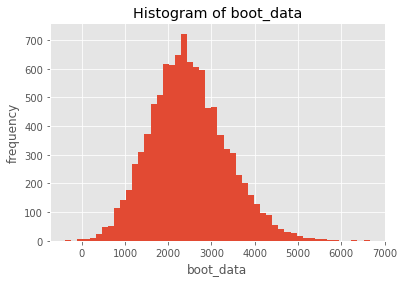

p_value for comparing with cntr1: 0.0052388011228444486, 
 доверительный интервал:                 0
0.025   873.073396
0.975  4359.195455


  0%|          | 0/10000 [00:00<?, ?it/s]

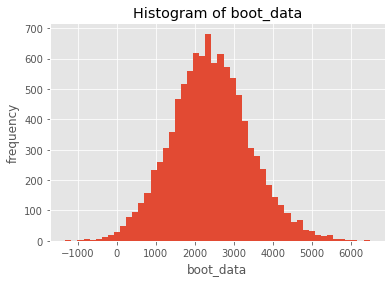

p_value for comparing with cntr2: 0.016166613884003027, 
 доверительный интервал:                 0
0.025   485.172639
0.975  4492.456944


In [128]:
#для мужчин
booted_data = get_bootstrap(unique_paid[(unique_paid['group_id'] == 'test') &
                                        (unique_paid['gender'] == 1)].revenue, 
                                unique_paid[(unique_paid['group_id'] == 'cntr1') &
                                        (unique_paid['gender'] == 1)].revenue, 
                                statistic = np.mean)
print(f'''p_value for comparing with cntr1: {booted_data["p_value"]}, \n доверительный интервал:{booted_data["ci"]}''')

booted_data = get_bootstrap(unique_paid[(unique_paid['group_id'] == 'test') &
                                        (unique_paid['gender'] == 1)].revenue, 
                                unique_paid[(unique_paid['group_id'] == 'cntr2') &
                                        (unique_paid['gender'] == 1)].revenue, 
                                statistic = np.mean)
print(f'''p_value for comparing with cntr2: {booted_data["p_value"]}, \n доверительный интервал:{booted_data["ci"]}''')

  0%|          | 0/10000 [00:00<?, ?it/s]

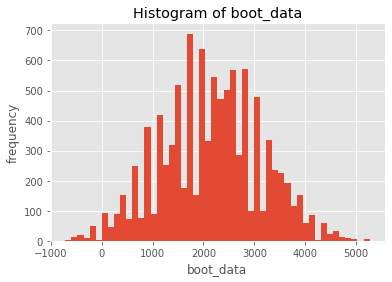

p_value for comparing with cntr1: 0.027029920470041977, 
 доверительный интервал:             0
0.025   276.25
0.975  4059.25


  0%|          | 0/10000 [00:00<?, ?it/s]

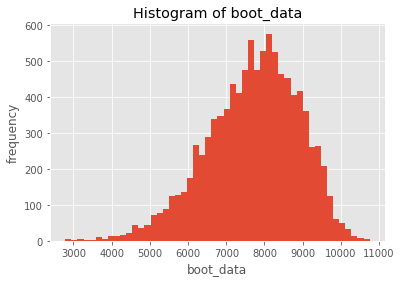

p_value for comparing with cntr2: 1.3962652868543075e-10, 
 доверительный интервал:                 0
0.025  5103.428571
0.975  9703.571429


In [129]:
#для женщин
booted_data = get_bootstrap(unique_paid[(unique_paid['group_id'] == 'test') &
                                        (unique_paid['gender'] == 0)].revenue, 
                                unique_paid[(unique_paid['group_id'] == 'cntr1') &
                                        (unique_paid['gender'] == 0)].revenue, 
                                statistic = np.mean)
print(f'''p_value for comparing with cntr1: {booted_data["p_value"]}, \n доверительный интервал:{booted_data["ci"]}''')

booted_data = get_bootstrap(unique_paid[(unique_paid['group_id'] == 'test') &
                                        (unique_paid['gender'] == 0)].revenue, 
                                unique_paid[(unique_paid['group_id'] == 'cntr2') &
                                        (unique_paid['gender'] == 0)].revenue, 
                                statistic = np.mean)
print(f'''p_value for comparing with cntr2: {booted_data["p_value"]}, \n доверительный интервал:{booted_data["ci"]}''')

### 4. Интенсивность использования

Посмотрим корреляцию по переменным для тех пользователей, кто купил premium_no_trial. Мы видим, что это очевидные зависимые: revenue, avg_check, apc, is_premium. Из интересного, хоть и не такой значимой корреляции: views_count и coins, а также обратная корреляция с since_recent_visit. Посмотрим на views_count внимательнее.

In [130]:
unique_paid[unique_paid['product_type'] == 'premium_no_trial'].corr(method='spearman')

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,revenue,payment_id,avg_check,apc,visits_sum,last_day,since_recent_visit
uid,1.000000,0.007569,-0.112764,-0.306849,0.029915,0.067744,0.013953,0.114664,NaN,-0.203235,-0.032774,0.004820,0.064472,-0.011999,-0.033195,0.388252,0.436780,0.362693
age,0.007569,1.000000,0.014721,0.249426,-0.089531,0.562568,0.688068,0.370787,NaN,-0.048544,0.041755,0.068028,-0.021600,0.044053,0.028260,0.141922,0.129162,-0.160476
attraction_coeff,-0.112764,0.014721,1.000000,0.163571,0.058397,-0.081332,0.128365,-0.018112,NaN,-0.036214,-0.019304,0.066681,-0.002505,0.082870,-0.153351,-0.064279,-0.073819,-0.017916
coins,-0.306849,0.249426,0.163571,1.000000,NaN,0.132644,0.136778,0.564560,NaN,0.012681,0.596988,0.242194,0.018288,0.518109,0.326809,-0.102652,-0.170645,-0.144231
gender,0.029915,-0.089531,0.058397,NaN,1.000000,-0.107584,-0.124665,-0.266969,NaN,0.037686,0.123412,0.097948,0.022084,0.076165,0.084910,0.098883,0.115121,-0.082530
age_filter_start,0.067744,0.562568,-0.081332,0.132644,-0.107584,1.000000,0.277606,0.059180,NaN,-0.126425,-0.093590,-0.120145,-0.097165,-0.069794,-0.003397,-0.063285,-0.061445,0.119723
age_filter_end,0.013953,0.688068,0.128365,0.136778,-0.124665,0.277606,1.000000,0.339700,NaN,-0.070486,-0.036273,-0.013129,-0.116391,-0.002844,-0.037402,0.113764,0.107224,-0.096792
views_count,0.114664,0.370787,-0.018112,0.564560,-0.266969,0.059180,0.339700,1.000000,NaN,0.153089,0.258975,0.138110,0.149355,0.091987,0.260716,0.459283,0.409803,-0.312886
was_premium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_premium,-0.203235,-0.048544,-0.036214,0.012681,0.037686,-0.126425,-0.070486,0.153089,NaN,1.000000,0.307641,0.278304,0.580708,0.258416,0.126096,0.116314,0.090101,-0.219300


In [131]:
px.scatter(unique_paid[unique_paid['views_count'] < 2000], x='views_count', y = 'total_revenue', **plot_config)

In [132]:
views_clast = paid_df.views_count.quantile([.25, .5, .75]).to_list() #разобьем количества на группы по интенсивности взаимодействия с приложением

rarely = unique_paid[(unique_paid['views_count'] < views_clast[0])] #минимальные просмотры 
infrequently = unique_paid[(unique_paid['views_count'] > views_clast[0]) &
                 (unique_paid['views_count'] < views_clast[1])] #2 уровень частоты просмотров  
infrequently_2 = unique_paid[(unique_paid['views_count'] > views_clast[1]) &
                 (unique_paid['views_count'] < views_clast[2])] #3 уровень частоты просмотров 
frequently = unique_paid[(unique_paid['views_count'] > views_clast[2])] #чаще всего просматривают 

Из всех групп значимый результат показал только самые вовлеченные пользователи. Что, предположительно, влияет на лояльность, а значит на них меньше влияет повышение цены (в плане оттока)

  0%|          | 0/10000 [00:00<?, ?it/s]

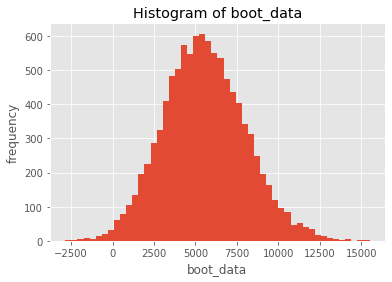

p_value for cntr1: 0.024505483578266637, 
 доверительный интервал:                  0
0.025    923.296773
0.975  10585.819981


  0%|          | 0/10000 [00:00<?, ?it/s]

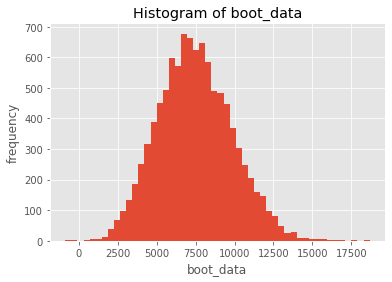

p_value for cntr2: 0.0017231862341979597, 
 доверительный интервал:                  0
0.025   3088.468692
0.975  12370.912912


In [133]:
booted_data = get_bootstrap(frequently[(frequently['group_id'] == 'test')].avg_check, 
                            frequently[(frequently['group_id'] == 'cntr1')].avg_check, 
                                statistic = np.mean)
print(f'''p_value for cntr1: {booted_data["p_value"]}, \n доверительный интервал:{booted_data["ci"]}''')

booted_data = get_bootstrap(frequently[(frequently['group_id'] == 'test')].avg_check, 
                            frequently[(frequently['group_id'] == 'cntr2')].avg_check, 
                                statistic = np.mean)
print(f'''p_value for cntr2: {booted_data["p_value"]}, \n доверительный интервал:{booted_data["ci"]}''')

__________________

## Итоги

**Анализ показал, что есть статистически значимые различия между контрольной и тестовыми группами. Нововведение  значимо увеличивает средний чек на 1200 - 4200 среди платящих пользователей!**

1. Для оценки статистической значимости был применен бустрэп, посколько выборки небольшие и этот метод позволяет построить доверительные интервалыразницы средних. 

2. Мы посчитали основные метрики по всему датасету, которые показали, что изменения стоимости подписки повлияли на конверсию в покупателя и конверсию в премиум-подписку. В то же время мы получили увеличение среднего чека, а показатель повторных покупок при этом не изменился. Что говорит о удачном тесте для платящих покупателей (или же лояльных покупателей, что дальше также подтверждается).

3. В попытках найти зацепки для оценки, на какие именно группы могли позитивно повлиять изменения, были:

        - Исследованы группы по 
                - странам (country), 
                - возрасту (age), 
                - гендеру и 
                - интенсивности использования (views_count)
        - Найдены показатели лояльности (was_premium)
       

4. Исследование показало, что смысл выкатывать обновление есть. Однако, лучше всего его оставить на уже лояльных пользователей (которые до этого покупали подписку (was_premium). Ожидаемый эффект от этого изменения - увеличение среднего чека на 1200-4200.

Дополнительно имеет смысл понаблюдать за отдельными категориями: 

    - страны Argentina и Italia
    - возраст до 25 лет и старше 38 
    - интенсивно использует приложение